In [1]:
!nvidia-smi

Tue Nov 23 09:56:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-11-23 09:56:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   133MB/s    in 1.2s    

2021-11-23 09:56:32 (133 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data=train_datagen.flow_from_directory(train_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url,num_classes=10):

  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,))
  
  model=tf.keras.Sequential([
                           feature_extractor_layer,
                           layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])

  return model

In [9]:
resnet_model=create_model(resnet_url)

In [11]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
resnet_history=resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                       experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20211123-100458
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 1.9186 - accuracy: 0.3427 - val_loss: 1.1864 - val_accuracy: 0.6372
Epoch 2/5
24/24 [==============================] - 22s 953ms/step - loss: 0.8948 - accuracy: 0.7387 - val_loss: 0.8674 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 22s 952ms/step - loss: 0.6227 - accuracy: 0.8360 - val_loss: 0.7596 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 22s 949ms/step - loss: 0.4731 - accuracy: 0.8747 - val_loss: 0.7375 - val_accuracy: 0.7584
Epoch 5/5
24/24 [==============================] - 22s 944ms/step - loss: 0.3849 - accuracy: 0.9147 - val_loss: 0.6873 - val_accuracy: 0.7756


In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

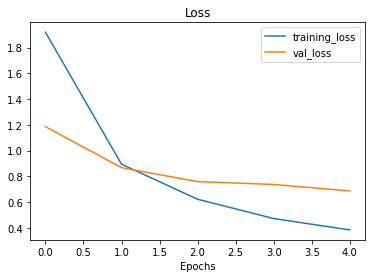

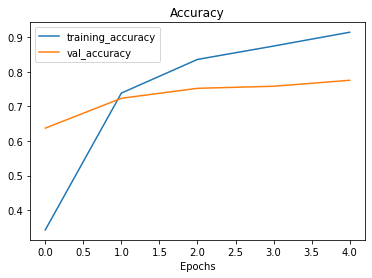

In [15]:
plot_loss_curves(resnet_history)

In [17]:
efficientnet_model=create_model(efficientnet_url,train_data.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history=efficientnet_model.fit(train_data,
                                            epochs=5,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                   experiment_name='efficientnetB0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20211123-101655
Epoch 1/5
24/24 [==============================] - 34s 939ms/step - loss: 1.7951 - accuracy: 0.4853 - val_loss: 1.2352 - val_accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 20s 846ms/step - loss: 1.0276 - accuracy: 0.7747 - val_loss: 0.8315 - val_accuracy: 0.8276
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7376 - accuracy: 0.8493 - val_loss: 0.6777 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 20s 845ms/step - loss: 0.5934 - accuracy: 0.8693 - val_loss: 0.5952 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 20s 848ms/step - loss: 0.5019 - accuracy: 0.8867 - val_loss: 0.5441 - val_accuracy: 0.8664


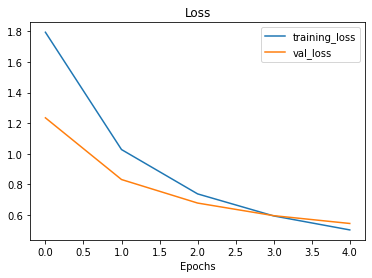

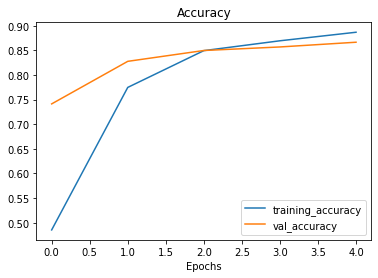

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=dn29kNucqnufnKQAjmVwmbpIgaVh7Y&prompt=consent&access_type=off

In [20]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/QZ59uQEJRnCYKGTzpGLvKg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   QZ59uQEJRnCYKGTzpGLvKg
	Created              2021-11-23 10:28:16 (3 minutes ago)
	Updated              2021-11-23 10:28:18 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5795363
Total: 1 experiment(s)
